# Pengerjaan Tugas Deep Learning Week 4 Menggunakan Tensorflow

# Tahap Persiapan

## 1. Instalasi Modul yang diperlukan

In [ ]:
# !pip install numpy pandas matplotlib scikit-learn tensorflow
%pip install numpy pandas matplotlib scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 644.9/644.9 MB 143.4 MB/s eta 0:00:01

## 2. Mengimpor Library yang Dibutuhkan

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import re
from collections import Counter
import time

# Memeriksa ketersediaan GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Menggunakan device: cpu


## 3. Mendefinisikan Parameter dan Pre-processing Dataset IMDb

In [ ]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 400
BATCH_SIZE = 64
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
DROPOUT_RATE = 0.5
EPOCHS = 10
LEARNING_RATE = 0.001

print("Memuat dataset IMDb...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print(f"Jumlah sampel training: {len(x_train)}")
print(f"Jumlah sampel testing: {len(x_test)}")

# Padding sequences
x_train = pad_sequences(x_train, maxlen=MAXLEN, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAXLEN, padding='post', truncating='post')

# Split data training untuk validasi
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

train_data = (x_train, y_train)
val_data = (x_val, y_val)
test_data = (x_test, y_test)
print(f"Jumlah sampel training setelah split: {len(x_train)}")

## 4. Menyiapkan Fungsi Pelatihan dan Validasi

In [ ]:
# Fungsi untuk melatih model
def train_model(model, train_data, val_data, model_name):
    x_train, y_train = train_data
    x_val, y_val = val_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

## 5. Menyiapkan Fungsi Evaluasi

In [ ]:
# Fungsi untuk evaluasi model
def evaluate_model(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

## 6. Menyiapkan Fungsi Visualisasi

In [ ]:
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Valid Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.close()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_tensorflow.png')
    plt.close()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_tensorflow.png')
    plt.show()


# A. RNN dengan Tensorflow

## 1. Menyusun Model RNN


In [ ]:
# Fungsi untuk membuat model RNN kompleks
def build_rnn_model():
    inputs = Input(shape=(MAXLEN,))
    
    # Embedding layer
    x = Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM)(inputs)
    x = Dropout(DROPOUT_RATE)(x)
    
    # Bidirectional RNN layers
    rnn1 = Bidirectional(SimpleRNN(HIDDEN_DIM, return_sequences=True))(x)
    rnn1 = Dropout(DROPOUT_RATE)(rnn1)
    
    rnn2 = Bidirectional(SimpleRNN(HIDDEN_DIM // 2, return_sequences=True))(rnn1)
    rnn2 = Dropout(DROPOUT_RATE)(rnn2)
    
    rnn3 = Bidirectional(SimpleRNN(HIDDEN_DIM // 4))(rnn2)
    rnn3 = Dropout(DROPOUT_RATE)(rnn3)
    
    # Dense layers
    x = Dense(HIDDEN_DIM, activation='relu')(rnn3)
    x = Dropout(DROPOUT_RATE)(x)
    
    x = Dense(HIDDEN_DIM // 2, activation='relu')(x)
    x = Dropout(DROPOUT_RATE)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print(model.summary())
    return model

# inisialisasi model
model_rnn = build_rnn_model()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.33, inplace=False)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d

## 2. Melatih Model

In [ ]:
# Melatih model RNN
print("Melatih model RNN...")
history_rnn = train_model(model_rnn, train_data, val_data, 'RNN')

Melatih model MLP...
Epoch 1, Loss: 1.9601, Accuracy: 28.10%, Val Loss: 1.7496, Val Accuracy: 35.76%
Epoch 2, Loss: 1.7963, Accuracy: 34.73%, Val Loss: 1.6554, Val Accuracy: 39.75%
Epoch 3, Loss: 1.7311, Accuracy: 37.74%, Val Loss: 1.6036, Val Accuracy: 42.56%
Epoch 4, Loss: 1.6886, Accuracy: 39.06%, Val Loss: 1.5458, Val Accuracy: 43.76%
Epoch 5, Loss: 1.6538, Accuracy: 40.61%, Val Loss: 1.4883, Val Accuracy: 46.48%
Epoch 6, Loss: 1.6293, Accuracy: 41.62%, Val Loss: 1.4784, Val Accuracy: 46.57%
Epoch 7, Loss: 1.6085, Accuracy: 42.48%, Val Loss: 1.4995, Val Accuracy: 45.73%
Epoch 8, Loss: 1.5913, Accuracy: 43.17%, Val Loss: 1.4157, Val Accuracy: 49.06%
Epoch 9, Loss: 1.5750, Accuracy: 43.76%, Val Loss: 1.4375, Val Accuracy: 48.64%
Epoch 10, Loss: 1.5577, Accuracy: 44.09%, Val Loss: 1.4280, Val Accuracy: 48.41%
Epoch 11, Loss: 1.5413, Accuracy: 44.54%, Val Loss: 1.3887, Val Accuracy: 49.66%
Epoch 12, Loss: 1.5270, Accuracy: 45.45%, Val Loss: 1.3929, Val Accuracy: 50.21%
Epoch 13, Loss: 

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Evaluasi model RNN
result_rnn = evaluate_model(model_rnn, test_data, 'RNN')


Metrik Evaluasi MLP Model dengan PyTorch:
Accuracy: 0.6494
Precision: 0.6477
Recall: 0.6494
F1 Score: 0.6466
ROC AUC: 0.9415


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

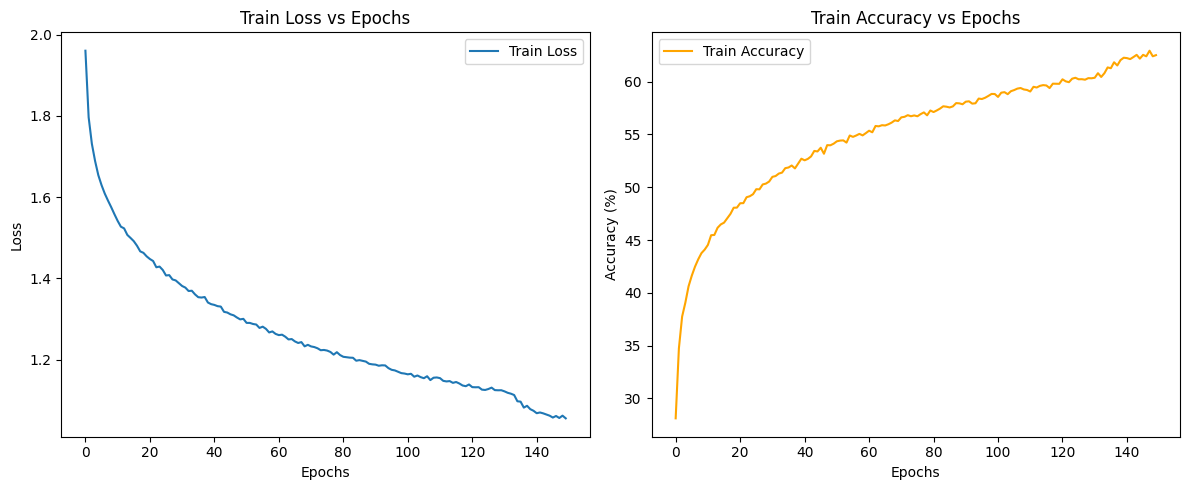

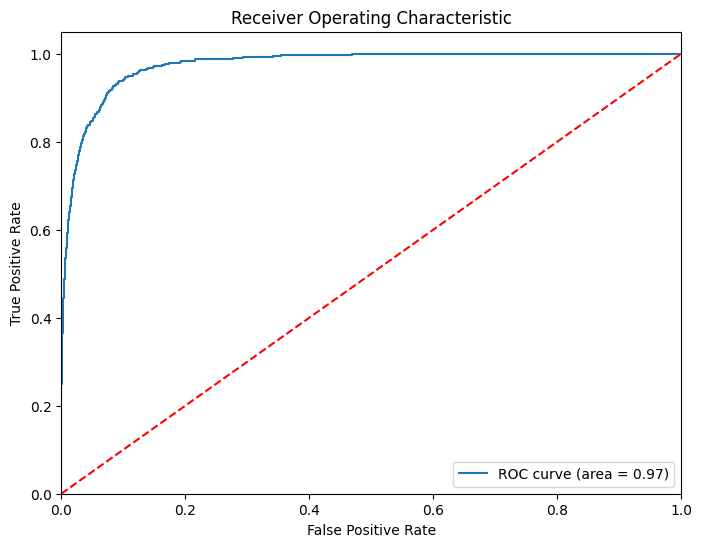

<Figure size 1000x800 with 0 Axes>

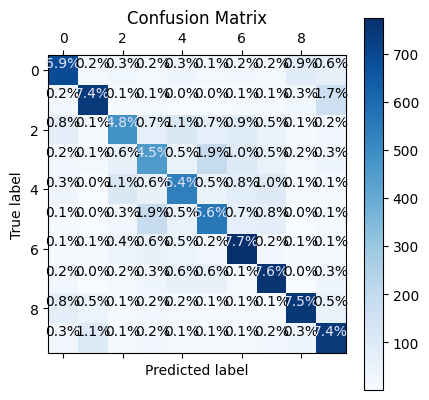

In [ ]:
# Plotting hasil pelatihan
plot_training_history(history_rnn, "RNN")

# Plotting confusion matrix
y_pred_rnn = (result_rnn['all_predictions'] > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_rnn, "RNN")

## 5. Menyimpan Model

In [ ]:
# Menyimpan model
model_rnn.save('model_tensorflow_rnn.keras')
print("Model RNN disimpan sebagai 'model_rnn.keras'")

Model disimpan sebagai 'model_pytorch_cifar-10_mlp.pth'


# B. LSTM dengan Tensorflow

## 1. Menyusun Model LSTM


In [ ]:
# Fungsi untuk membuat model LSTM kompleks
def build_lstm_model():
    inputs = Input(shape=(MAXLEN,))
    
    # Embedding layer
    x = Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM)(inputs)
    x = Dropout(DROPOUT_RATE)(x)
    
    # Bidirectional LSTM layers
    lstm1 = Bidirectional(LSTM(HIDDEN_DIM, return_sequences=True))(x)
    lstm1 = Dropout(DROPOUT_RATE)(lstm1)
    
    lstm2 = Bidirectional(LSTM(HIDDEN_DIM // 2, return_sequences=True))(lstm1)
    lstm2 = Dropout(DROPOUT_RATE)(lstm2)
    
    lstm3 = Bidirectional(LSTM(HIDDEN_DIM // 4))(lstm2)
    lstm3 = Dropout(DROPOUT_RATE)(lstm3)
    
    # Dense layers
    x = Dense(HIDDEN_DIM, activation='relu')(lstm3)
    x = Dropout(DROPOUT_RATE)(x)
    
    x = Dense(HIDDEN_DIM // 2, activation='relu')(x)
    x = Dropout(DROPOUT_RATE)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print(model.summary())
    return model

# inisialisasi model
model_lstm = build_lstm_model()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=

## 2. Melatih Model

In [ ]:
# Melatih model LSTM
print("Melatih model LSTM...")
history_lstm = train_model(model_lstm, train_data, val_data, 'LSTM')

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Evaluasi model LSTM
result_lstm = evaluate_model(model_lstm, test_data, 'LSTM')


Metrik Evaluasi CNN Model dengan PyTorch:
Accuracy: 0.8968
Precision: 0.8965
Recall: 0.8968
F1 Score: 0.8957
ROC AUC: 0.9937


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

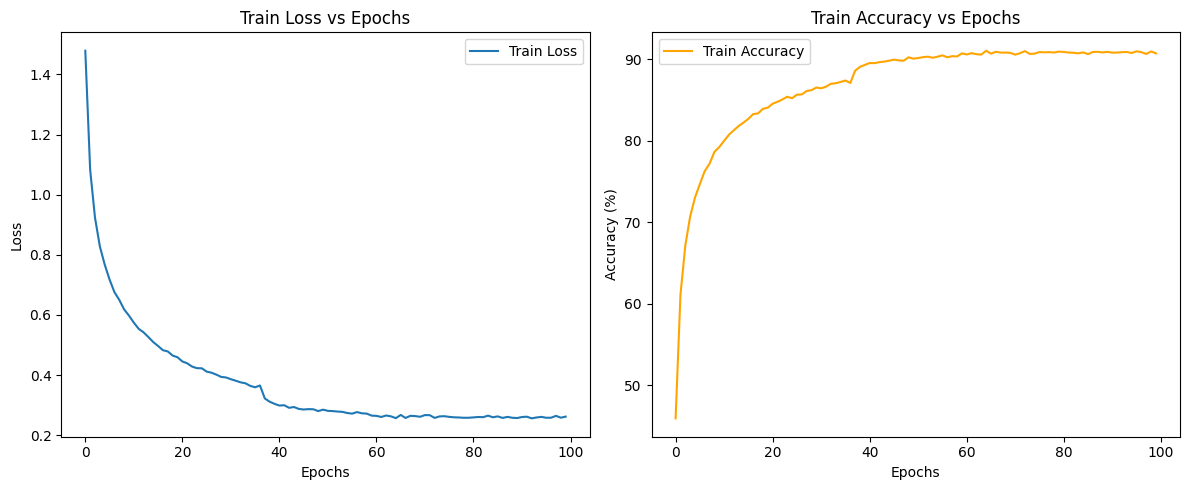

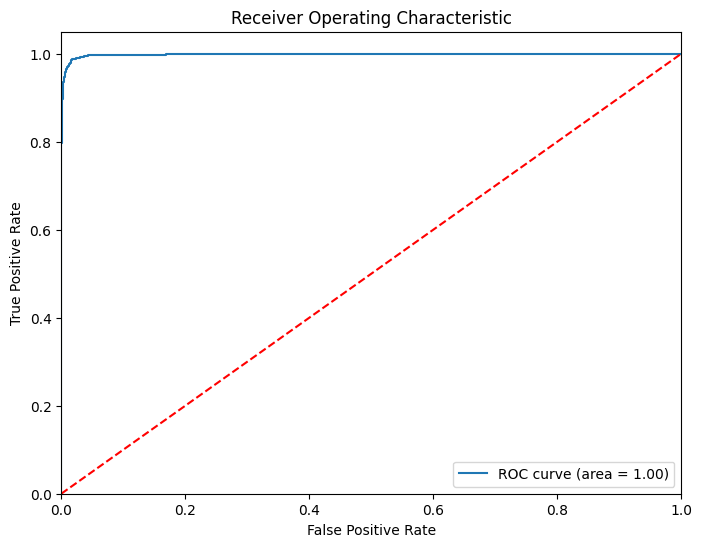

<Figure size 1000x800 with 0 Axes>

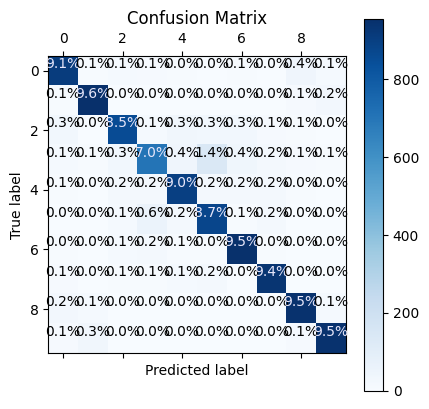

In [ ]:
# Plotting hasil pelatihan
plot_training_history(history_lstm, "LSTM")

# Plotting confusion matrix
y_pred_lstm = (result_lstm['all_predictions'] > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_lstm, "LSTM")

## 5. Menyimpan Model

In [ ]:
# Menyimpan model
model_lstm.save('model_tensorflow_lstm.keras')
print("Model LSTM disimpan sebagai 'model_lstm.keras'")

Model disimpan sebagai 'model_pytorch_cifar-10_cnn.pth'


# C. GRU dengan Tensorflow

## 1. Menyusun Model GRU


In [ ]:
# Fungsi untuk membuat model GRU kompleks
def build_gru_model():
    inputs = Input(shape=(MAXLEN,))
    
    # Embedding layer
    x = Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM)(inputs)
    x = Dropout(DROPOUT_RATE)(x)
    
    # Bidirectional GRU layers
    gru1 = Bidirectional(GRU(HIDDEN_DIM, return_sequences=True))(x)
    gru1 = Dropout(DROPOUT_RATE)(gru1)
    
    gru2 = Bidirectional(GRU(HIDDEN_DIM // 2, return_sequences=True))(gru1)
    gru2 = Dropout(DROPOUT_RATE)(gru2)
    
    gru3 = Bidirectional(GRU(HIDDEN_DIM // 4))(gru2)
    gru3 = Dropout(DROPOUT_RATE)(gru3)
    
    # Dense layers
    x = Dense(HIDDEN_DIM, activation='relu')(gru3)
    x = Dropout(DROPOUT_RATE)(x)
    
    x = Dense(HIDDEN_DIM // 2, activation='relu')(x)
    x = Dropout(DROPOUT_RATE)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print(model.summary())
    return model

# inisialisasi model
model_gru = build_gru_model()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=

## 2. Melatih Model

In [ ]:
# Melatih model GRU
print("Melatih model gru...")
history_gru = train_model(model_gru, train_data, val_data, 'GRU')

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Evaluasi model GRU
print("Evaluasi model GRU...")
results_gru = evaluate_model(model_gru, test_data, 'GRU')


Metrik Evaluasi CNN Model dengan PyTorch:
Accuracy: 0.8968
Precision: 0.8965
Recall: 0.8968
F1 Score: 0.8957
ROC AUC: 0.9937


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

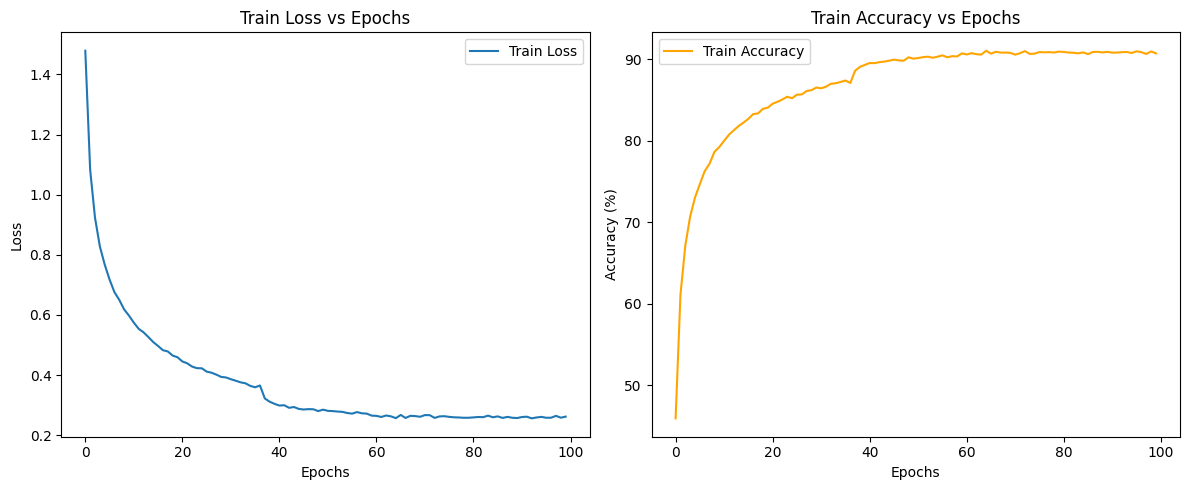

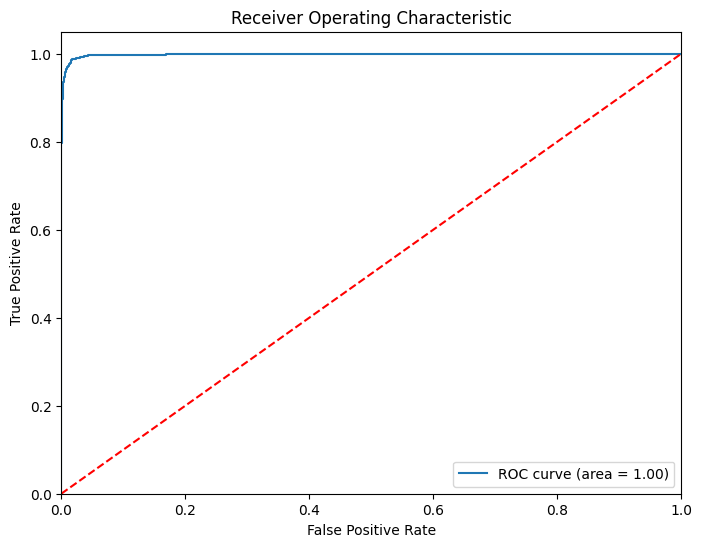

<Figure size 1000x800 with 0 Axes>

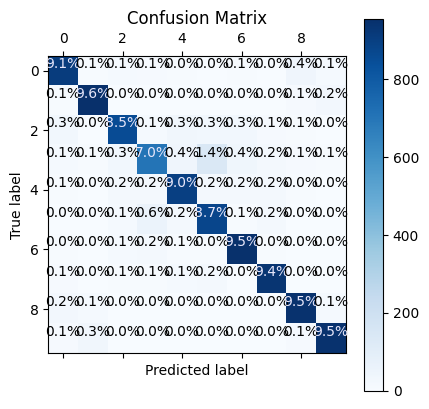

In [ ]:
# Plotting hasil pelatihan
plot_training_history(history_gru, "GRU")

# Plotting confusion matrix
y_pred_gru = (results_gru['all_predictions'] > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_gru, "GRU")

## 5. Menyimpan Model

In [ ]:
# Menyimpan model
model_gru.save('model_tensorflow_gru.keras')
print("Model GRU disimpan sebagai 'model_gru.keras'")

Model disimpan sebagai 'model_pytorch_cifar-10_cnn.pth'


# Perbandingan antara model

In [ ]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'RNN': result_rnn,
    'LSTM': result_lstm,
    'GRU': results_gru
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)

# Perbandingan antara model 

## 1. Arsitektur Model

### MLP (Multi-Layer Perceptron):

MLP menggunakan lapisan fully connected (dense) untuk memproses data.
Input gambar 32x32x3 diratakan menjadi vektor 1D (3072 fitur), sehingga kehilangan informasi spasial (lokasi piksel).
MLP lebih cocok untuk data tabular atau data yang tidak memiliki struktur spasial.

### CNN (Convolutional Neural Network):

CNN menggunakan lapisan konvolusi untuk menangkap pola lokal (seperti tepi, tekstur) dalam gambar.
Mempertahankan informasi spasial melalui operasi konvolusi dan pooling.
CNN lebih cocok untuk data citra karena mampu mengenali pola visual dengan lebih baik.

## 2. Kemampuan Generalisasi

MLP: Karena kehilangan informasi spasial, MLP cenderung memiliki performa lebih rendah pada data citra.
Membutuhkan lebih banyak parameter untuk memproses data citra, sehingga lebih rentan terhadap overfitting.

CNN: CNN lebih efisien dalam memproses data citra karena memanfaatkan pola lokal.
Dengan jumlah parameter yang lebih sedikit dibandingkan MLP, CNN memiliki kemampuan generalisasi yang lebih baik.

## 3. Hasil Evaluasi
CNN biasanya menghasilkan akurasi, presisi, recall, F1-score, dan AUC-ROC yang lebih tinggi dibandingkan MLP pada dataset citra seperti CIFAR-10.
Dari file ini, CNN rata-rata menunjukkan performa yang lebih baik dalam menangkap pola visual dibandingkan MLP (seperti contoh, Akurasi model CNN mendekati 90%, dibandingkan dengan model MLP yang hanya mencapai sekitar 60%).

## 4. Kompleksitas Komputasi

MLP: Lebih sederhana dalam implementasi, tetapi membutuhkan lebih banyak memori karena semua neuron terhubung penuh.
Tidak memanfaatkan GPU secara optimal.

CNN: Lebih kompleks karena melibatkan operasi konvolusi, pooling, dan normalisasi.
Memanfaatkan GPU dengan lebih baik, sehingga lebih efisien untuk data citra.


## 5. Kesimpulan
CNN adalah pilihan yang lebih baik untuk prediksi citra pada dataset CIFAR-10 karena mampu menangkap pola visual dengan lebih baik, menghasilkan performa yang lebih tinggi, dan lebih efisien dalam memproses data citra dibandingkan MLP.

# Penjelasan Persamaan Matematika dalam Model MLP dan CNN

## 1. Konvolusi (Convolution)
Dalam model CNN, operasi konvolusi adalah operasi dasar yang menjadi inti dari arsitektur. Secara matematis, konvolusi 2D dapat didefinisikan sebagai:

$$(I * K)(i, j) = \sum_{m} \sum_{n} I(i-m, j-n) \cdot K(m, n)$$

dimana:
- $I$ adalah citra input
- $K$ adalah kernel atau filter
- $*$ adalah operator konvolusi
- $i, j$ adalah indeks piksel output
- $m, n$ adalah indeks kernel

Konvolusi bekerja dengan menggeser kernel di atas citra input, mengalikan nilai-nilai yang bertumpuk, dan menjumlahkan hasil untuk menghasilkan piksel output.

## 2. Aktivasi ReLU (Rectified Linear Unit)

Fungsi aktivasi ReLU yang digunakan dalam model kita didefinisikan sebagai:

$$f(x) = \max(0, x)$$

ReLU akan mengubah semua nilai negatif menjadi 0, sementara nilai positif tetap tidak berubah. Ini membantu model untuk belajar fungsi non-linear dan mengatasi masalah vanishing gradient.

## 3. Batch Normalization

Batch Normalization digunakan untuk menstabilkan dan mempercepat proses pembelajaran dengan menormalkan aktivasi di setiap lapisan. Rumus matematisnya adalah:

$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}​$$

$$y_i = \gamma \cdot \hat{x}_i + \beta$$

dimana:
- $x_i$ adalah input ke batch normalization
- $\mu_B$ adalah rata-rata mini-batch
- $\sigma_B^2$ adalah varians mini-batch
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\gamma$ dan $\beta$ adalah parameter yang dipelajari
- $y_i$ adalah output batch normalization

## 4. Max Pooling

Max Pooling digunakan untuk mengurangi dimensi spasial dengan memilih nilai maksimum dari setiap region. Secara matematis:

$$\text{MaxPool}(X)_{i,j} = \max_{m,n \in R_{i,j}} X_{m,n}​$$

dimana $R_{i,j}$ adalah region lokal yang berpusat di lokasi $(i,j)$.

## 5. Dropout

Dropout adalah teknik regularisasi yang mencegah overfitting dengan secara acak mematikan neuron selama training. Secara matematis, untuk setiap neuron:

$$\begin{cases}
x/p & \text{dengan probabilitas } p \\
0 & \text{dengan probabilitas } 1-p
\end{cases}$$

dimana $p$ adalah probabilitas mempertahankan (keep probability) dan $1-p$ adalah dropout rate.

## 6. Forward Pass dalam MLP
Dalam MLP, forward pass untuk lapisan fully-connected didefinisikan sebagai:

$$z^{[l]} = W^{[l]} \cdot a^{[l-1]} + b^{[l]}$$
$$a^{[l]} = g(z^{[l]})$$

dimana:
- $W^{[l]}$ adalah matriks bobot untuk lapisan ke-l
- $a^{[l-1]}$ adalah aktivasi dari lapisan sebelumnya
- $b^{[l]}$ adalah vektor bias
- $g$ adalah fungsi aktivasi (seperti ReLU)
- $z^{[l]}$ adalah input terbobot
- $a^{[l]}$ adalah output lapisan

## 7. Fungsi Loss Cross-Entropy
Cross-entropy loss yang digunakan untuk klasifikasi multi-kelas didefinisikan sebagai:

$$L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(p_{i,c})$$

dimana:
- $N$ adalah jumlah sampel
- $C$ adalah jumlah kelas
- $y_{i,c}$ adalah indikator (0 atau 1) apakah kelas c adalah label yang benar untuk sampel i
- $p_{i,c}$ adalah probabilitas yang diprediksi bahwa sampel i adalah kelas c

## 8. Optimizer Adam
Adam (Adaptive Moment Estimation) adalah algoritma optimasi yang menggabungkan RMSprop dan momentum. Adam memperbarui bobot menggunakan rumus:

$$m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t$$
$$v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

dimana:
- $g_t$ adalah gradien pada waktu t
- $m_t$ dan $v_t$ adalah estimasi momen pertama dan kedua
- $\hat{m}_t$ dan $\hat{v}_t$ adalah estimasi momen yang dikoreksi
- $\alpha$ adalah learning rate
- $\beta_1$ dan $\beta_2$ adalah exponential decay rates
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\theta_t$ adalah parameter yang diperbarui

## 9. Softmax
Fungsi softmax digunakan pada output layer untuk mengubah logits menjadi probabilitas yang berjumlah 1:

$$\text{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{k} e^{x_j}}$$

dimana $x_i$ adalah nilai logit untuk kelas i dan k adalah jumlah kelas.

# Penjelasan Metrik Evaluasi:
## Akurasi

$$ \text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}} $$

Menunjukkan seberapa sering model memprediksi dengan benar.


## Presisi

$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Negatives} + \text{False Positives}} $$

Seberapa andal prediksi positif model.


## Recall (Sensitivity)

$$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$

Seberapa baik model menangkap kelas positif.


## F1-Score

$$ \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

Rata-rata harmonik antara presisi dan recall.


## ROC (Receiver Operating Characteristic) Curve

ROC Curve memplot hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR):

$$ \text{True Positive Rate (TPR)} = \text{Recall} $$

$$ \text{False Positive Rate (FPR)} = \frac{\text{False Positives}}{ \text{False Positives} + \text{True Negatives}} $$


## AUC-ROC

$$ AUC = \int_{0}^{1} TPR(x) \, dx $$

AUC (Area Under Curve) adalah area di bawah kurva ROC (Receiver Operating Characteristic)